In [ ]:
!pip install torch torchvision d2l

In [ ]:
!pip uninstall matplotlib -y

In [ ]:
!pip install matplotlib # to fix a weird matplotlib bug

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X = torch.normal(0., 1., (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

covariance matrix: 
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


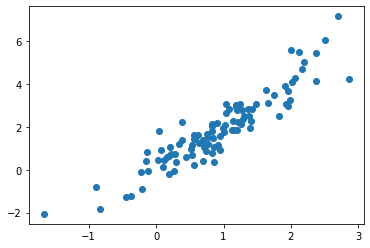

In [ ]:
plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())
print(f'covariance matrix: \n{torch.matmul(A.T, A)}')

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20

batch_size = 8
data_iter = d2l.load_array((data, ), batch_size)

net_G = nn.Sequential(nn.Linear(2, 2))

net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1)
)

loss = nn.BCEWithLogitsLoss(reduction='sum')

losses_D = []
losses_G = []

for w in net_D.parameters():
    nn.init.normal_(w, 0, 0.02)
for w in net_G.parameters():
    nn.init.normal_(w, 0, 0.02)

trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)

for epoch in range(num_epochs):
    for (X,) in data_iter:
        batch_size = X.shape[0]
        Z = torch.normal(0., 1., size=(batch_size, latent_dim))

        # update D
        ones = torch.ones((batch_size,), device=X.device)
        zeros = torch.zeros((batch_size,), device=X.device)
        trainer_D.zero_grad()
        real_Y = net_D(X)
        fake_X = net_G(Z)
        fake_Y = net_D(fake_X.detach()) # detach gradient for net_G because no need to compute it
        loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) + loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
        losses_D.append(loss_D)
        loss_D.backward()
        trainer_D.step()

        # update G
        ones = torch.ones((batch_size,), device=Z.device)
        trainer_G.zero_grad()
        fake_X = net_G(Z) # could reuse from update_D
        fake_Y = net_D(fake_X) # recomputation necessary since net_D is changed
        loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
        losses_G.append(loss_G)
        loss_G.backward()
        trainer_G.step()

print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}')

loss_D 4.864, loss_G 6.599


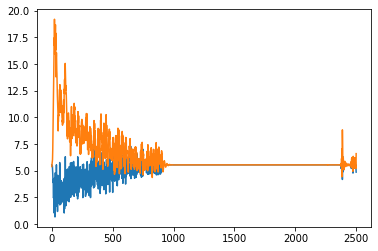

In [ ]:
plt.plot(np.arange(len(losses_D)), np.array(losses_D), np.array(losses_G))

In [ ]:
# visualize generated examples
Z = torch.normal(0., 1., size=(100, latent_dim))
fake_X = net_G(Z).detach().numpy()

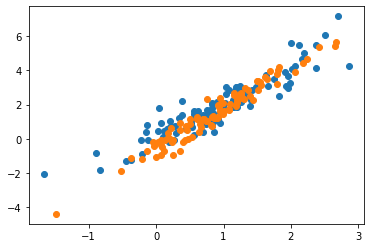

In [ ]:
plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())
plt.scatter(fake_X[:, 0], fake_X[:, 1])